In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logsumexp

Generate the arm values

In [12]:
def generate_arm_vals(time_steps):
    avg_freq = np.random.uniform(0, 0.02)
    last_switch = 0
    hi, lo = np.random.uniform(), - np.random.uniform()
    is_hi = True if np.random.uniform() < 0.5 else False
    vals = []
    for t in range(time_steps + 1):
        if is_hi:
            vals.append(hi)
        else:
            vals.append(lo)
        if np.random.uniform() < avg_freq and t - last_switch > 30:
            last_switch = t
            is_hi = not is_hi
    return vals

Thompson Sampling with Recursive Bayes

In [13]:
def recursive_bayes(num_arms, time_steps, maxes, all_arms):
    arm_uses = np.array([0 for _ in range(num_arms)])
    arm_means = np.array([0 for _ in range(num_arms)])
    regret = [0 for _ in range(time_steps + 1)]
    for t in range(1, time_steps + 1):
        max_ = maxes[t]
        arm_idx = np.argmax(np.random.normal(arm_means, 0.25)) # Thompson sampling
        arm_uses[arm_idx] += 1
        n = arm_uses[arm_idx]
        arm_val = all_arms[arm_idx, t] + np.random.normal(0, 0.25)
        arm_means[arm_idx] = (1 - 1/(n+1))* arm_means[arm_idx] + (1/(n+1))*arm_val 

        # update regret
        regret[t] = max_ - arm_val
    return regret


Thompson Sampling with BOCD

In [14]:
def BOCD(num_arms, T, limit_dim, maxes, all_arms):

    # BOCD stuff
    log_R = -np.inf * np.ones((num_arms, limit_dim + 1, limit_dim + 1)) # arm, j, i --> P(i | j) of arm j
    log_R[:, 0, 0] = 0
    # log_message = np.array([0])
    H = 0.016
    log_H = np.log(H)
    log_1mH = np.log(1 - H)
    arm_means = [np.array([0]) for _ in range(num_arms)] # params
    log_message = [np.array([0]) for _ in range(num_arms)]

    print('finished setup...')

    # bandit stuff
    arm_uses = np.array([0 for _ in range(num_arms)])
    regret = [0 for _ in range(T + 1)]

    def select_action(t):
        # sample from RL posterior
        samples = []
        for arm in range(num_arms):
            N = arm_uses[arm]
            # sample from RL posterior
            sample_rl = np.random.choice(N + 1, p = np.exp(log_R[arm, N, :N + 1]))
            # sample from mean of sampled RL
            sample = np.random.normal(arm_means[arm][sample_rl], 0.25)
            samples.append(sample)
        return np.argmax(samples)

    def update(arm_idx, arm_val, N):
        # eval pred. probs
        log_pis = np.log(norm(arm_means[arm_idx], 0.25).pdf(arm_val))

        # calc growth probs
        log_growth_probs = log_pis + log_message[arm_idx] + log_1mH

        # calc changepoint probs
        log_cp_prob = logsumexp(log_pis + log_message[arm_idx] + log_H)

        # calc evidence
        new_log_joint = np.append(log_cp_prob, log_growth_probs)

        # Determine run length distribution.
        log_R[arm_idx, N+1, :N+2]  = new_log_joint
        log_R[arm_idx, N+1, :N+2] -= logsumexp(new_log_joint)

        arm_means[arm_idx] = np.append([0], (1 - 1/(N+2)) * arm_means[arm_idx] + arm_val * (1/(N+2)))
        log_message[arm_idx] = new_log_joint


    for t in range(1, T + 1):
        max_ = maxes[t]
        # Thompson sampling of RL and value
        arm_idx = select_action(t)
        N = arm_uses[arm_idx]
        arm_val = all_arms[arm_idx, t] + np.random.normal(0, 0.25)

        # update BOCD, arm model
        if N < limit_dim: # this is so my PC doesnt crash
            update(arm_idx, arm_val, N)
            arm_uses[arm_idx] += 1


        # update regret
        regret[t] = max_ - arm_val

    return regret

UCB

In [15]:
def UCB(num_arms, time_steps, maxes, all_arms):
    arm_uses = [0.0000000001 for _ in range(num_arms)]
    arm_avgs = [0 for _ in range(num_arms)]
    regret = [0 for _ in range(time_steps + 1)]
    for t in range(1, time_steps + 1):

        # choose best arm
        confidence = (1 + t*(np.log(t)**2))
        A = arm_avgs + confidence * np.sqrt(np.log(t) / arm_uses)

        # choose best arm
        arm_idx = np.argmax(A)
        arm_uses[arm_idx] += 1
        n = arm_uses[arm_idx]
        arm_val = all_arms[arm_idx, t] + np.random.normal(0, 0.25)
        arm_avgs[arm_idx] = (1 - 1/(n+1))* arm_avgs[arm_idx] + (1/(n+1))*arm_val

        # update regret
        regret[t] = maxes[t] - arm_val
    return regret

UCBAM

In [48]:
from sortedcontainers import SortedList

def UCBAM(num_arms, time_steps, maxes, all_arms):
    arm_uses = [0.0000000001 for _ in range(num_arms)]
    arm_means = [0 for _ in range(num_arms)]
    arm_data = [SortedList([]) for _ in range(num_arms)]
    observations = [None for _ in range(time_steps + 1)]
    regret = [0 for _ in range(time_steps + 1)]
    known = False
    for t in range(1, time_steps + 1):
        if known:
            # Thompson sampling
            arm_idx = np.argmax([np.random.normal(mean, 0.25) for mean in arm_means])
        else:
            # UCB
            confidence = 1 + t*(np.log(t))**2
            arm_idx = np.argmax(arm_means + confidence * np.sqrt(np.log(t) / arm_uses))

        arm_val = all_arms[arm_idx, t] + np.random.normal(0, 0.25)
        observations[t] = arm_val
        arm_uses[arm_idx] += 1

        if arm_val**2 <= (arm_val - arm_means[arm_idx])**2:
            known = False
        else:
            known = True

        # BAM update chosen arm: somewhat greedy procedure.
        arm_val
        curr_mean = 0
        W_count = 0
        chosen_arm_data = arm_data[arm_idx]
        if len(chosen_arm_data) > 0:
            lo, hi = chosen_arm_data.bisect_left(arm_val) - 1, chosen_arm_data.bisect_right(arm_val) - 1
            while True:
                new_mean_lo = curr_mean*(W_count / (W_count + 1)) + chosen_arm_data[lo] * (1/(W_count + 1)) if lo > -1 else 1000
                new_mean_hi = curr_mean*(W_count / (W_count + 1)) + chosen_arm_data[hi] * (1/(W_count + 1)) if hi < len(chosen_arm_data) else 1000
                    
                if (arm_val - new_mean_lo)**2 <= (arm_val - curr_mean)**2:
                    lo -= 1
                    curr_mean = new_mean_lo
                elif (arm_val - new_mean_hi)**2 <= (arm_val - curr_mean)**2:
                    hi += 1
                    curr_mean = new_mean_hi
                else:
                    break
                W_count += 1
        
        arm_means[arm_idx] = curr_mean
        chosen_arm_data.add(arm_val)

        # update regret
        regret[t] = maxes[t] - arm_val
    return regret

Run Experiment

In [49]:
def experiment(num_arms):
    time_steps = 10000
    all_arms = []
    for arm in range(num_arms):
        all_arms.append(generate_arm_vals(time_steps))

    all_arms = np.array(all_arms)
    maxes = all_arms.max(axis = 0)

    regret_recursive_bayes = recursive_bayes(num_arms, time_steps, maxes, all_arms)
    regret_BOCD = BOCD(num_arms, time_steps, 8000 if num_arms == 10 else 5000, maxes, all_arms)
    regret_UCB = UCB(num_arms, time_steps, maxes, all_arms)
    regret_UCBAM = UCBAM(num_arms, time_steps, maxes, all_arms)


    return regret_recursive_bayes, regret_BOCD, regret_UCB, regret_UCBAM

10 arms experiment

finished setup...
finished setup...
finished setup...
finished setup...
finished setup...


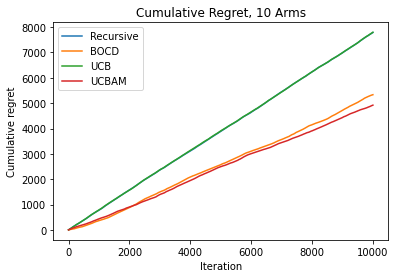

In [51]:
seeds_recursive = []
seeds_BOCD = []
seeds_UCB = []
seeds_UCBAM = []

for seed in range(5):
    results = experiment(10)
    seeds_recursive.append(results[0])
    seeds_BOCD.append(results[1])
    seeds_UCB.append(results[2])
    seeds_UCBAM.append(results[3])

regret_recursive = np.array(seeds_recursive).mean(axis = 0)
regret_BOCD = np.array(seeds_BOCD).mean(axis = 0)
regret_UCB = np.array(seeds_UCB).mean(axis = 0)
regret_UCBAM = np.array(seeds_UCBAM).mean(axis = 0)

plt.plot(np.cumsum(regret_recursive), label = 'Recursive')
plt.plot(np.cumsum(regret_BOCD), label = 'BOCD')
plt.plot(np.cumsum(regret_UCB), label = 'UCB')
plt.plot(np.cumsum(regret_UCBAM), label = 'UCBAM')
plt.xlabel('Iteration')
plt.ylabel('Cumulative regret')
plt.title('Cumulative Regret, 10 Arms')
plt.legend()
plt.show()

50 arms experiment

finished setup...
finished setup...
finished setup...
finished setup...
finished setup...


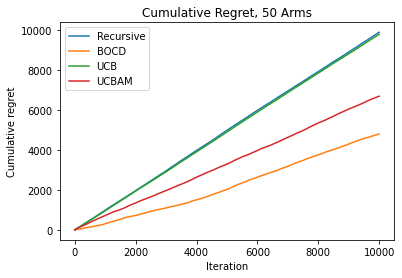

In [53]:
seeds_recursive = []
seeds_BOCD = []
seeds_UCB = []
seeds_UCBAM = []

for seed in range(5):
    results = experiment(50)
    seeds_recursive.append(results[0])
    seeds_BOCD.append(results[1])
    seeds_UCB.append(results[2])
    seeds_UCBAM.append(results[3])

regret_recursive = np.array(seeds_recursive).mean(axis = 0)
regret_BOCD = np.array(seeds_BOCD).mean(axis = 0)
regret_UCB = np.array(seeds_UCB).mean(axis = 0)
regret_UCBAM = np.array(seeds_UCBAM).mean(axis = 0)

plt.plot(np.cumsum(regret_recursive), label = 'Recursive')
plt.plot(np.cumsum(regret_BOCD), label = 'BOCD')
plt.plot(np.cumsum(regret_UCB), label = 'UCB')
plt.plot(np.cumsum(regret_UCBAM), label = 'UCBAM')
plt.xlabel('Iteration')
plt.ylabel('Cumulative regret')
plt.title('Cumulative Regret, 50 Arms')
plt.legend()
plt.show()

Visualize noise-less arm values

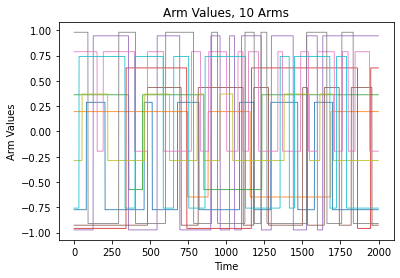

In [56]:
time_steps = 10000
num_arms = 10
all_arms = []
for arm in range(num_arms):
    all_arms.append(generate_arm_vals(10000))

for arm in all_arms:
    plt.plot(arm[:2000], linewidth = 0.8)
plt.title('Arm Values, 10 Arms')
plt.xlabel('Time')
plt.ylabel('Arm Values')
plt.show()